# Fisheye Visual Odometry with Homography

This notebook streamlines the existing pose recovery workflow into three focused:

- Undistort fisheye frames to verify calibration quality
- Track and filter feature correspondences between rectified frames
- Integrate homography-derived motions into a relative trajectory and plot the path

In [1]:
import json
from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from pose_helpers import analyze_trajectory, plot_trajectory, write_video_with_trajectory, draw_tracks, TrajectoryResult, TrajectoryVideoWriter

plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 11

In [2]:
# --- Configuration ---
PROJECT_ROOT = Path("./flight")
VIDEO_PATH = PROJECT_ROOT / "recording.mp4"
CALIBRATION_PATH = PROJECT_ROOT / "calibration-params.json"

if not VIDEO_PATH.exists():
    raise FileNotFoundError(VIDEO_PATH)
if not CALIBRATION_PATH.exists():
    raise FileNotFoundError(CALIBRATION_PATH)

print(f"Video: {VIDEO_PATH}")
print(f"Calibration: {CALIBRATION_PATH}")

Video: flight\recording.mp4
Calibration: flight\calibration-params.json


In [3]:
# --- Calibration & undistortion helpers ---
def load_camera_intrinsics(json_path: Path) -> Tuple[np.ndarray, np.ndarray, Tuple[int, int]]:
    """Return camera matrix K, distortion vector D, and image size."""
    with open(json_path, "r") as f:
        load = json.load(f)

    load = load["cameras"][0]
    d = np.array(load["distortionCoefficients"])
    cx, cy = load["principalPointX"], load["principalPointY"]
    fx, fy = load["focalLengthX"], load["focalLengthY"]
    height, width = load["imageHeight"], load["imageWidth"]
    K = np.array([[fx, 0, cx], ## s = 0 
                 [0, fy, cy],
                 [0, 0, 1]]) 
    return K, d, (width, height)

def create_fisheye_rectification_maps(
    K: np.ndarray,
    D: np.ndarray,
    image_size: Tuple[int, int],
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Pre-compute undistortion maps for faster remapping during VO."""
    map1, map2 = cv.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size, cv.CV_16SC2)
    return K, map1, map2 ## new K?

def undistort_with_maps(frame: np.ndarray, map1: np.ndarray, map2: np.ndarray) -> np.ndarray:
    """Apply pre-computed undistortion maps to a frame."""
    return cv.remap(frame, map1, map2, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)
    


def read_frame(video_path: Path, index: int) -> np.ndarray:
    cap = cv.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open {video_path}")
    cap.set(cv.CAP_PROP_POS_FRAMES, index)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Failed to read frame {index}")
    return frame


def read_frame_pair(video_path: Path, base_index: int, offset: int) -> Tuple[np.ndarray, np.ndarray]:
    first = read_frame(video_path, base_index)
    second = read_frame(video_path, base_index + offset)
    return first, second

In [4]:
K, D, image_size = load_camera_intrinsics(CALIBRATION_PATH)
print("Camera intrinsics loaded")
print(f"Image size   : {image_size[0]} x {image_size[1]}")
print(f"Focal lengths: fx={K[0, 0]:.2f}, fy={K[1, 1]:.2f}")
print(f"Principal pt : cx={K[0, 2]:.2f}, cy={K[1, 2]:.2f}")
print(f"Distortion   : {D.ravel()}")

NEW_K, undistort_map1, undistort_map2 = create_fisheye_rectification_maps(K, D, image_size)
print("Rectification maps prepared.")

Camera intrinsics loaded
Image size   : 1920 x 1080
Focal lengths: fx=590.07, fy=589.52
Principal pt : cx=1015.07, cy=571.36
Distortion   : [-0.03678765  0.00404803 -0.00777366  0.00206872]
Rectification maps prepared.


#### Explain the methods used
    `create_fisheye_rectification_maps`:
        `D` contains the 4 fisheye coefficients and uses opencv fisheye distortion model

## 1. Undistortion Check

Rectify a representative frame with the fisheye calibration to confirm that straight edges appear linear and the field of view remains sufficient.

Raw frame shape        : (1080, 1920, 3)
Undistorted frame shape: (1080, 1920, 3)


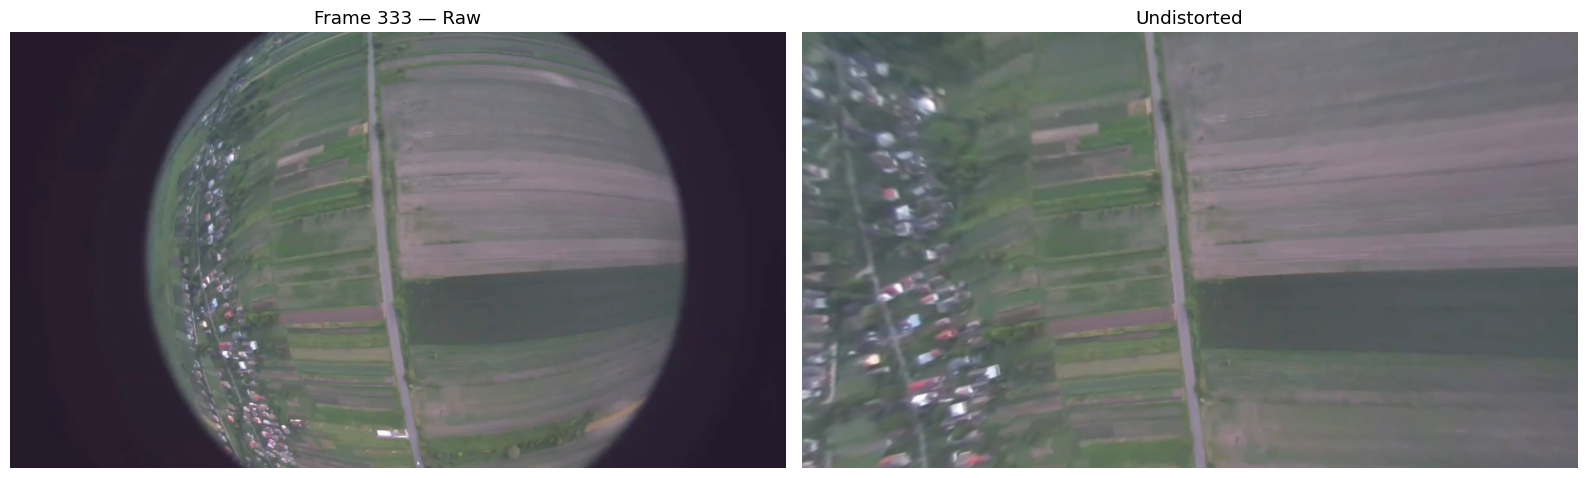

In [5]:
sample_frame_index = 333
raw_frame = read_frame(VIDEO_PATH, sample_frame_index)
undistorted_frame = undistort_with_maps(raw_frame, undistort_map1, undistort_map2)

print(f"Raw frame shape        : {raw_frame.shape}")
print(f"Undistorted frame shape: {undistorted_frame.shape}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(cv.cvtColor(raw_frame, cv.COLOR_BGR2RGB))
axes[0].set_title(f"Frame {sample_frame_index} — Raw")
axes[0].axis("off")

axes[1].imshow(cv.cvtColor(undistorted_frame, cv.COLOR_BGR2RGB))
axes[1].set_title("Undistorted")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## 2. Feature Detection and Tracking

Use Shi–Tomasi corners (`cv.goodFeaturesToTrack`) for feature detection and Lucas–Kanade optical flow on the undistorted frames. You're encouraged to experiment with other feature detection algorithms (SIFT, ORB, etc)

## Helpers

In [19]:
THRESHOLDS_ROI = [round(x * 0.05, 2) for x in range(20, 0, -1)]
MIN_FEATURE_DISTANCE = 8 ## SOFIA CAN EXPERIMENT FOR BETTER VO PERFORMANCE
DEFAULT_LK_PARAMETERS = dict( winSize  = (21, 21),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.01))

def auto_lower_threshold_roi(roi, start_x, start_y, exp_value_corners):
    """Lower the threshold ot shi-tomasi to some extend. If it is a bad flat region outputs None"""
    for threshold in THRESHOLDS_ROI:
        corners = cv.goodFeaturesToTrack(roi, exp_value_corners, threshold, MIN_FEATURE_DISTANCE)
        if corners is not None and len(corners) >= exp_value_corners:
            corners_ = []
            for corner in corners:

                corner[0][0] += start_x
                corner[0][1] += start_y
                corners_.append(corner)
            return corners_
    
    

In [20]:
def good_features(
    gray: np.ndarray,
    max_corners: int = 3000,
    grid_rows: int = 8,
    grid_cols: int = 8,
) -> Optional[np.ndarray]:
    """
    Uniformly sample features  across the image by dividing it into a grid
    and extracting up to max_corners features distributed among cells.
    """

    corners = []
        

    batch_step_y, batch_step_x = gray.shape[0] // grid_rows, gray.shape[1] // grid_cols

    area_diff = (gray.shape[0] * gray.shape[1]) / (batch_step_y * batch_step_x)
    max_expected_corners = max_corners / area_diff

    for col in range(grid_cols):
        start_y = col * batch_step_y
        end_y = min(start_y + batch_step_y - 1, gray.shape[0]) ## guard

        for row in range(grid_rows):
            start_x = row * batch_step_x
            end_x = min(start_x + batch_step_x - 1, gray.shape[1])

            roi = gray[start_y:end_y, start_x:end_x]
            cur_corners = auto_lower_threshold_roi(roi, start_x, start_y, int(max_expected_corners))
            
            if cur_corners is None:
                continue
            corners += cur_corners

    return np.array(corners)
    
def compute_good_feature_tracks(
    gray1: np.ndarray,
    gray2: np.ndarray,
    prev_pts: Optional[np.ndarray] = None,
    max_corners: int = 3000,
    lk_params: Optional[dict] = None,
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Run Lucas-Kanade tracking on Shi-Tomasi features between two grayscale frames.

    Returns:
        prev_pts: points on the first frame with shape (N, 1, 2) or None
        curr_pts: corresponding points on the second frame with shape (N, 1, 2) or None
        status_mask: boolean array marking which points were successfully tracked
    """
    lk_params = lk_params if lk_params is not None else DEFAULT_LK_PARAMETERS
    
    
    cur_pts = good_features(gray2, max_corners, 8, 8)

    if (prev_pts is None):
        prev_pts = good_features(gray1, max_corners, 8, 8)
    
    # print(f"{prev_pts.shape = }")
    # print(f"{cur_pts.shape = }")
    
    new_points, status, _ = cv.calcOpticalFlowPyrLK(gray1,
            gray2, prev_pts, cur_pts, **lk_params)
    
    status = status.ravel().astype(bool)
    
    return prev_pts, new_points, status

def track_good_features(
    img1_bgr: np.ndarray,
    img2_bgr: np.ndarray,
    max_corners: int = 3000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Shi-Tomasi + LK. Green = tracked correspondences, red dots = lost tracks in img1."""
    gray1 = cv.cvtColor(img1_bgr, cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(img2_bgr, cv.COLOR_BGR2GRAY)

    prev_pts, curr_pts, status_all = compute_good_feature_tracks(
        gray1,
        gray2,
        prev_pts=None,
        max_corners=max_corners
    )

    if prev_pts is None or curr_pts is None or status_all is None:
        raise RuntimeError("Feature tracking failed")

    status_all = np.asarray(status_all, dtype=bool)
    pts1 = prev_pts.reshape(-1, 2)
    pts2 = curr_pts.reshape(-1, 2)

    good_prev = pts1[status_all]
    good_curr = pts2[status_all]
    lost_prev = pts1[~status_all]

    h1, w1 = img1_bgr.shape[:2]
    h2, w2 = img2_bgr.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    vis[:h1, :w1] = img1_bgr
    vis[:h2, w1:w1 + w2] = img2_bgr

    # draw tracked correspondences (green)
    for (x1, y1), (x2, y2) in zip(good_prev, good_curr):
        x1, y1, x2, y2 = map(lambda v: int(np.round(v).item()), (x1, y1, x2, y2))
        cv.line(vis, (x1, y1), (x2 + w1, y2), (0, 255, 0), 1, cv.LINE_AA)
        cv.circle(vis, (x1, y1), 3, (0, 255, 0), -1, cv.LINE_AA)
        cv.circle(vis, (x2 + w1, y2), 3, (0, 255, 0), -1, cv.LINE_AA)

    # draw lost points (red) on img1
    for (x1, y1) in lost_prev:
        x1, y1 = int(np.round(x1).item()), int(np.round(y1).item())
        cv.circle(vis, (x1, y1), 3, (0, 0, 255), -1, cv.LINE_AA)

    vis_rgb = cv.cvtColor(vis, cv.COLOR_BGR2RGB)

    # Return tracked pairs only + status over all initial points
    return pts1, pts2, status_all, vis_rgb

#### Explain the methods used:
    `good_features`:
        Since the points have to be sampled uniformly, we devided the input image into smalles sub-grids(in user defined way).
        Then we used Shi-Tomasi corner detector to extract meaningful features. For each sub-grid the expected value of key points is computed and then the threshold of Shi-Tomasi response is moved. This is done to extract better features at each sub-grid.
    This method is not perfect, but it does it job well

    `compute_good_feature_tracks`:
        We used opencv LK method to truck the key points is previously defined way

## TESTING

In [21]:
sample_frame_index_0 = 333
raw_frame_0 = read_frame(VIDEO_PATH, sample_frame_index_0)
undistorted_frame_0 = undistort_with_maps(raw_frame_0, undistort_map1, undistort_map2)

sample_frame_index_1 = 335
raw_frame_1 = read_frame(VIDEO_PATH, sample_frame_index_1)
undistorted_frame_1 = undistort_with_maps(raw_frame_1, undistort_map1, undistort_map2)


test_gray_frame_0 = cv.cvtColor(undistorted_frame_0, cv.COLOR_BGR2GRAY)
test_gray_frame_1 = cv.cvtColor(undistorted_frame_1, cv.COLOR_BGR2GRAY)


f0 = good_features(test_gray_frame_0, 1500, 8, 8)
f1 = good_features(test_gray_frame_1, 1500, 8, 8)



outputs = compute_good_feature_tracks(test_gray_frame_0, test_gray_frame_1, f0, 1500)

Detected features frame 1: 128
Tracked points frame 2: 98


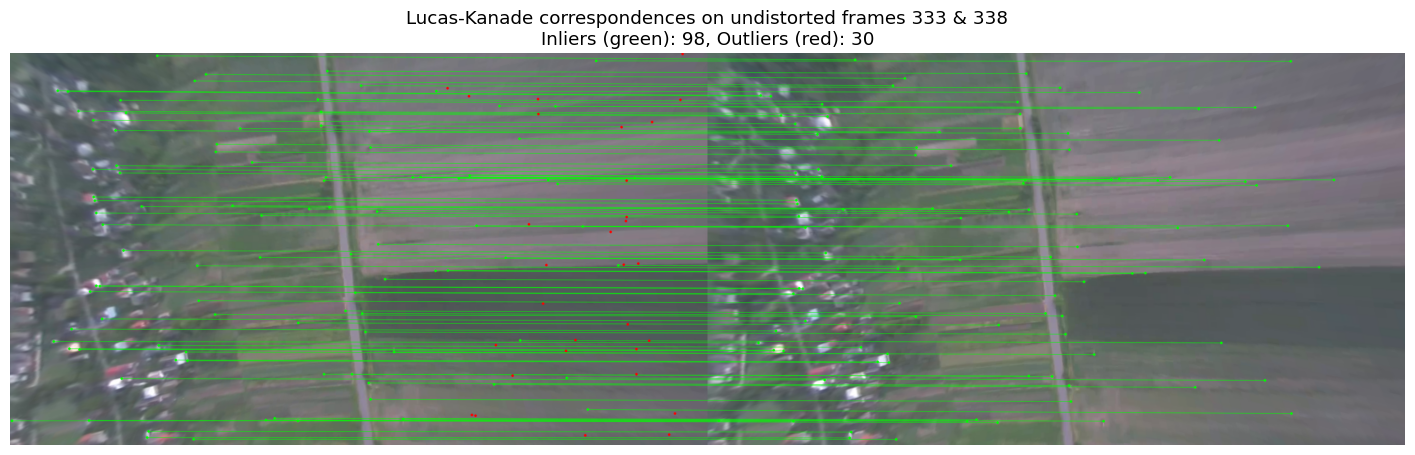

In [22]:
offset_frame = 5
raw_a, raw_b = read_frame_pair(VIDEO_PATH, sample_frame_index, offset_frame)
rect_a = undistort_with_maps(raw_a, undistort_map1, undistort_map2)
rect_b = undistort_with_maps(raw_b, undistort_map1, undistort_map2)

prev_pts, curr_pts, inlier_mask, vis_matches = track_good_features(
    rect_a,
    rect_b,
    max_corners=150,
)

num_tracked = len(prev_pts)
num_inliers = int(inlier_mask.sum())

print(f"Detected features frame 1: {num_tracked}")
print(f"Tracked points frame 2: {num_inliers}")

plt.figure(figsize=(18, 8))
plt.imshow(vis_matches)
plt.title(
    f"Lucas-Kanade correspondences on undistorted frames {sample_frame_index} & {sample_frame_index + offset_frame}\n"
    f"Inliers (green): {num_inliers}, Outliers (red): {num_tracked - num_inliers}"
)
plt.axis("off")
plt.show()

## 3. Homography-Based Trajectory (Fisheye)

Using only feature detections, track corners through the sequence, estimate inter-frame homographies, and pick the motion hypothesis that keeps pose as close as possible to nadir (homework assumption). The accumulated poses form a relative path (scale remains arbitrary).

In [24]:
from tqdm import tqdm


def choose_pose_candidate(
    Rs: List[np.ndarray],
    ts: List[np.ndarray],
    normals: List[np.ndarray]
) -> Optional[Tuple[np.ndarray, np.ndarray]]:
    """
    Select the pose (R, t) whose associated normal is closest to nadir ([0, 0, 1])
    and return it.

    Hint: Use cosine similarity to find the best match.
    """

    # if normals is None:
    #     raise ValueError("Normals are not provided")

    # expected_normal = np.array([0.0, 0.0, 1.0])
        
    if normals is None or len(normals) == 0:
        return None
    if Rs is None or ts is None or len(Rs) == 0 or len(ts) == 0:
        return None

    expected_normal = np.array([0.0, 0.0, 1.0], dtype=float)

    best_idx = None
    best_cos = -np.inf

    for i, n in enumerate(normals):
        n = np.asarray(n, dtype=float).reshape(-1)
        if n.shape[0] != 3:
            continue

        n_norm = np.linalg.norm(n)
        if n_norm == 0.0:
            continue

        n_unit = n / n_norm
        exp_unit = expected_normal / np.linalg.norm(expected_normal)

        # Cosine similarity between normal and expected nadir
        cos_sim = float(np.dot(n_unit, exp_unit))

        if cos_sim > best_cos:
            best_cos = cos_sim
            best_idx = i

    if best_idx is None:
        return None

    return Rs[best_idx], ts[best_idx]


def recover_homography_trajectory(
    video_path: Path,
    map1: np.ndarray,
    map2: np.ndarray,
    K_rectified: np.ndarray,
    min_inliers: int = 60,
    min_points: int = 120,
    max_corners: int = 4000,
    output_video_path: Optional[Path] = None,
    draw_thickness: int = 1,
) -> TrajectoryResult:
    """
    Recover a trajectory from a video using homography-based pose estimation.
    
    Steps to implement:
    1. Undistort the current frame
    2. Track features from previous frame to current frame
    3. Handle cases where tracking fails (reacquire features if below min_inliers threshold)
    4. Filter tracked points based on status
    5. Check if enough points remain (reacquire features if below min_points threshold)
    6. Compute homography using RANSAC
    7. Check if homography is valid and has enough inliers (min_inliers threshold)
    8. Decompose homography to extract rotation and translation
    9. Update the camera pose (current_R and current_pos)
    10. Store trajectory data (timestamps, positions, inliers, frame_indices)
    11. Write frame with overlay to output video if enabled
    """
    cap = cv.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open {video_path}")

    fps = cap.get(cv.CAP_PROP_FPS)
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    print(f"Video FPS: {fps:.2f}, total frames: {total_frames}")

    ret, prev_raw = cap.read()
    if not ret:
        cap.release()
        raise RuntimeError("Could not read first frame")
    
    prev_rect = undistort_with_maps(prev_raw, map1, map2)
    h, w = prev_rect.shape[:2]

    video_writer = TrajectoryVideoWriter(output_video_path, fps, (w, h), draw_thickness)

    prev_gray = cv.cvtColor(prev_rect, cv.COLOR_BGR2GRAY)

    prev_pts = good_features(prev_gray, max_corners=max_corners)
    if prev_pts is None or len(prev_pts) == 0:
        print("Warning: could not detect initial features; trying again on first frame.")
        prev_pts = good_features(prev_gray, max_corners=max_corners)
        if prev_pts is None or len(prev_pts) == 0:
            cap.release()
            video_writer.release()
            raise RuntimeError("Failed to detect any features in the first frame.")

    timestamps: List[float] = []
    inliers: List[int] = []
    frame_indices: List[int] = []

    current_R = np.eye(3, dtype=float)
    current_pos = np.zeros(3, dtype=float)
    positions = [current_pos.copy()]

    processed = 0
    frame_index = 0

    with tqdm(total=total_frames, desc="Recovering Homography Trajectory") as pbar:
        while True:
            ret, curr_raw = cap.read()
            if not ret:
                break

            frame_index += 1
            video_writer.increment_frame()

            curr_rect = undistort_with_maps(curr_raw, map1, map2)
            curr_gray = cv.cvtColor(curr_rect, cv.COLOR_BGR2GRAY)

            prev_pts_tracked, curr_pts_all, status_all = compute_good_feature_tracks(
                prev_gray,
                curr_gray,
                prev_pts=prev_pts,
                max_corners=max_corners,
            )

            if prev_pts_tracked is None or curr_pts_all is None or status_all is None \
                or len(prev_pts_tracked) == 0:
                
                prev_pts = good_features(prev_gray, max_corners=max_corners)
                prev_gray = curr_gray
                pbar.update(1)
                continue

            status_all = np.asarray(status_all, dtype=bool).ravel()
            pts1_all = prev_pts_tracked.reshape(-1, 2)
            pts2_all = curr_pts_all.reshape(-1, 2)

            pts1 = pts1_all[status_all]
            pts2 = pts2_all[status_all]

            if pts1.shape[0] < min_points:
                prev_pts = good_features(prev_gray, max_corners=max_corners)
                prev_gray = curr_gray
                pbar.update(1)
                continue

            H, mask = cv.findHomography(pts1, pts2, cv.RANSAC, 3.0)
            if H is None or mask is None:
                prev_pts = good_features(prev_gray, max_corners=max_corners)
                prev_gray = curr_gray
                pbar.update(1)
                continue

            mask = mask.ravel().astype(bool)
            num_inliers = int(mask.sum())

            if num_inliers < min_inliers:
                status_msg = f"Too few inliers ({num_inliers})"
                status_color = (0, 0, 255)

                tracked_prev = pts1.reshape(-1, 1, 2).astype(np.float32)
                tracked_curr = pts2.reshape(-1, 1, 2).astype(np.float32)
                video_writer.write_frame_with_overlay(
                    curr_rect,
                    tracked_prev,
                    tracked_curr,
                    mask,
                    status_msg,
                    status_color,
                )

                prev_pts = good_features(curr_gray, max_corners=max_corners)
                prev_gray = curr_gray
                pbar.update(1)
                continue

            try:
                _, Rs, ts, normals = cv.decomposeHomographyMat(H, K_rectified)
            except cv.error as e:
                print(f"Homography decomposition failed at frame {frame_index}: {e}")
                prev_pts = good_features(curr_gray, max_corners=max_corners)
                prev_gray = curr_gray
                pbar.update(1)
                continue

            pose = choose_pose_candidate(Rs, ts, normals)
            if pose is None:
                prev_pts = good_features(curr_gray, max_corners=max_corners)
                prev_gray = curr_gray
                pbar.update(1)
                continue

            R_rel, t_rel = pose
            t_rel = np.asarray(t_rel, dtype=float).reshape(3,)

            delta_pos = current_R @ t_rel
            current_pos = current_pos + delta_pos
            current_R = R_rel @ current_R

            positions.append(current_pos.copy())
            timestamps.append(frame_index / fps)
            inliers.append(num_inliers)
            frame_indices.append(frame_index)
            processed += 1

            tracked_prev = pts1.reshape(-1, 1, 2).astype(np.float32)
            tracked_curr = pts2.reshape(-1, 1, 2).astype(np.float32)

            status_msg = f"Inliers: {num_inliers}"
            status_color = (0, 255, 0)

            video_writer.write_frame_with_overlay(
                curr_rect,
                tracked_prev,
                tracked_curr,
                mask,
                status_msg,
                status_color,
            )

            prev_gray = curr_gray
            prev_inlier_pts = tracked_curr[mask].reshape(-1, 1, 2)
            prev_pts = prev_inlier_pts if prev_inlier_pts.shape[0] >= min_points else good_features(prev_gray, max_corners=max_corners)

            pbar.update(1)

    cap.release()
    video_writer.release()

            
    print(f"Processed {processed} frames, recovered {len(frame_indices)} poses")
    if output_video_path is not None:
        print(f"Wrote overlay video: {output_video_path}")

    return TrajectoryResult(
        timestamps=timestamps,
        positions=np.vstack(positions),
        inliers=inliers,
        frame_indices=frame_indices,
    )


#### Explain the methods used:
    `choose_pose_candidate`:
        Selects the best camera pose from multiple homography decomposition solutions. When a homography is decomposed, it yields up to 4 possible pose solutions (R, t, normal). This function computes the cosine similarity between each plane normal and the expected direction [0, 0, 1]. It returns the pose whose normal is closest to pointing downward, which aligns with the assumption that the camera is looking at a roughly horizontal ground plane during flight.

    `recover_homography_trajectory`:
        Reconstructs the camera's 3D trajectory from a video by tracking features and estimating frame-to-frame motion using homography using the methods we created above. It does the following:
        - Undistors each frame using fisheye calibration.
        - Tracks feature points between two consecutive frames using LC optical flow.
        - Computes a homography matrix from matched pointes using RANSAC.
        - Decomposes homography to extract possible rotation and translation and selects the correct pose using choose_pose_candidate.
        - Accumulates relative motion to build a global trajectory.
        - Redetecs features if tracking quallity drops below thresholds.
        - outputs trajectory data and optical anotated video.  

Starting homography-based trajectory recovery...
Video FPS: 19.85, total frames: 3561


Recovering Homography Trajectory: 100%|█████████▉| 3560/3561 [39:47<00:00,  1.49it/s]  



Processed 3509 frames, recovered 3509 poses
Wrote overlay video: undistorted_features.mp4


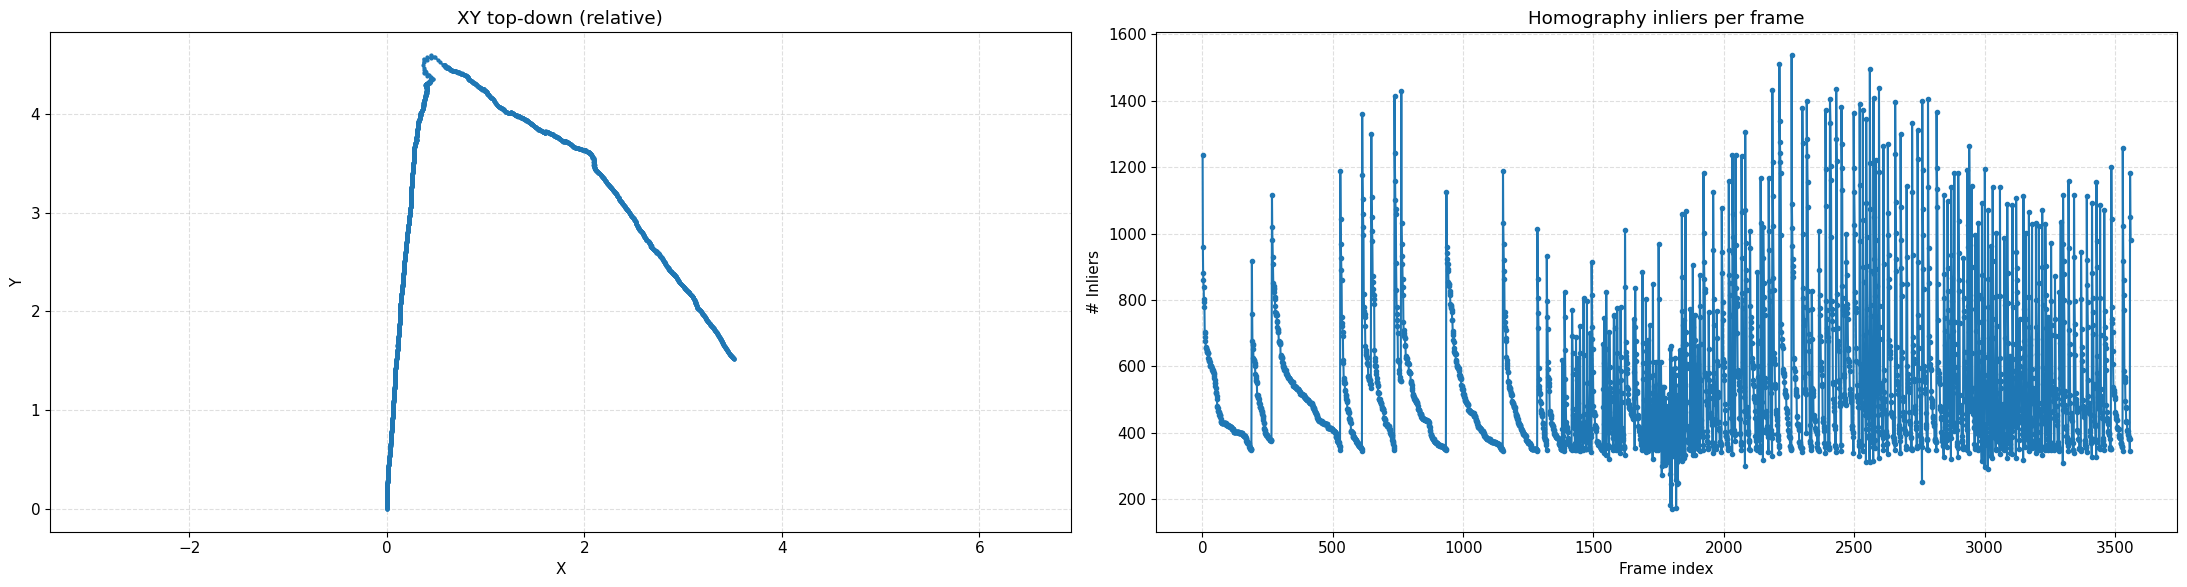

In [25]:
import pathlib
print("Starting homography-based trajectory recovery...")
traj_result = recover_homography_trajectory(
    VIDEO_PATH,
    undistort_map1,
    undistort_map2,
    NEW_K,
    min_inliers=80,
    max_corners=2000,
    min_points=350,
    output_video_path=Path("undistorted_features.mp4")
)

plot_trajectory(traj_result)


In [14]:
write_video_with_trajectory(
    "undistorted_features.mp4",
    traj_result,
    output_path="trajectory_overlay.mp4",
    stride=1,
)

Writing video with trajectory:  99%|█████████▉| 3495/3528 [15:35<00:08,  3.73frame/s]

Output video saved to trajectory_overlay.mp4


--- Trajectory Alignment Report ---
Calibrated on first 500 of 3509 overlapping frames.

Similarity Alignment Parameters:
  Scale = 188.1435
  Rotation = 88.86°
  Translation = [-366.12, -293.73] m

Error (Calibration Segment):
  RMS = 0.84 m
  Max = 1.64 m

Error (Full Trajectory):
  RMS = 176.33 m

---------------------------------

Ground truth trajectory length: 1753.66 m
Aligned VO trajectory length:   2051.18 m


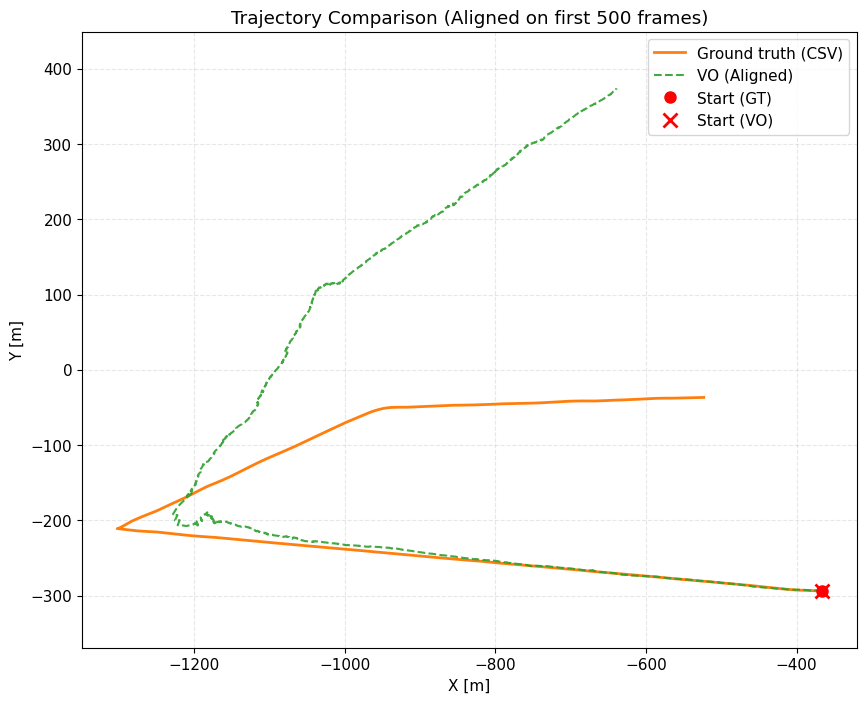

In [26]:
# analyze_trajectory is imported from pose_helpers
analyze_trajectory(traj_result, Path("flight/flight_trajectory_coordinates.csv"))